# Entities as Experts

This notebook is a code implementation of the paper "Entities as Experts: Sparse Memory Access with Entity Supervision" by Févry, Baldini Soares, FitzGerald, Choi, Kwiatowski.

## Problem definition and high-level model description

We want to perform question answering on typical one-shot questions that require external knowledge or context. For example, in order to answer the question "Which country was Charles Darwin born in?" one needs some text providing answers on typical structured scenarios.

In this case, however, we want to rely on knowledge-graph extracted information. For example, in the question given here, we can prune out unrelated to the antropologist and evolution theorist Charles Darwins, e.g. Charles River, Darwin City etc. 

In the paper, the authors propose to augment BERT in the task of cloze-type question answering by leveraging an Entity Memory extracted from e.g. a Knoweldge Graph.

![Entity as Experts description](images/eae_highlevel.png)

The Entity Memory is a simple bunch of embeddings of entities extracted from a Knowledge Graph. Relationships are ignored (see the Facts as Experts paper and notebook to see how they could be used).

## Datasets

> We assume access to a corpus $D={(xi,mi)}$,where all entity mentions are detected but not necessarily  all  linked  to  entities.   We  use  English Wikipedia as our corpus, with a vocabulary of 1m entities. Entity links come from hyperlinks, leading to 32m 128 byte contexts containing 17m entity links.

In the appendix B, it is explained that:

> We build our training corpus of contexts paired with entity mention labels from the 2019-04-14 dump of English Wikipedia. We first divide each article into chunks of 500 bytes,resulting in a corpus of 32 million contexts withover 17 million entity mentions. We restrict our-selves  to  the  one  million  most  frequent  entities
(86% of the linked mentions).

Given that the dump 2019-04-14 is not available at the time of writing, we will adopt the revision 2020-11-01.

Entities are thus partially extracted by link annotations (e.g. they associate with each token a mention if that token belongs to a wikipedia url).

## Mention Detection

> In addition to the Wikipedia links, we annotaten each sentence with unlinked mention spans using the mention detector from Section 2.2

The mention detection head discussed in Section 2.2 is a simple BIO sequence: each token is annotated with a B (beginning), I (inside) or O (outside) if they are respectivelly beginning, inside or outside of a mention. The reason why we use both BIO and EL is to avoid inconsistencies.

There is a catch. In the paper, they explain they used Google NLP APIs to perform entity detection and linking on large-scale Wikipedia entries, that is, to have a properly annotated Wikipedia dataset. We are going to use simple Wikipedia hyperlinks insteal (TODO: consider adding spacy annotation?).

NOTE FOR MYSELF: We don't *actually* perform entity linking here - as in, we don't train a classifier from the first $l_0$ layers. Instead we'll build pseudo embeddings and try to find the entity that best matches a pseudo embedding (see later).

HOWEVER, we do need that when training. The whole idea is that we get supervised data when training, however it is not always the case that we have this data at hand (see: TriviaQA, WebQuestions, ...).

## Entity Memory

The idea is pretty simple: we have as input $X_1$ and the mention spans $m_i = (e_i, s_{m_i}, t_{m_i})$ . Those are given as input. We don't care about e_i for the embedding calculation, but we DO care for the loss definition.

(Glossing over the Entity Memory calculation...)

When the entity detection is supervised, our obtained entity should be close to the found pseudo entity embedding.

$$
ELLoss = \sum_{m_i} \alpha_i \cdot \mathbb{1}_{e_{m_i} \ne e_{\emptyset}} , \qquad \alpha = softmax(E \cdot h_{m_i})
$$

($E$ is our `EntEmbed`, so $E * h_{m_i}$ is a vector, so $\alpha$ is a vector too (of shape $N$), and $h_{m_i}$ is a "pseudo entity embedding" ).

## Chunking
- In theory we should split articles by chunks of 500 bytes (assuming unicode encoding), and contexts are only 128 tokens long. For simplicity by now we only limit ourselves to the first paragraph only.

## Tokenization:

- BERT Tokenizer (e.g. Wordpiece) using lowercase vocabulary, limited to 128 distinct word-piece tokens.

## Learning hyperparameters

For pretraining:

> We use ADAM with a learning rate of 1e-4.  We apply warmup for the first 5% of training, decaying the learning rate afterwards.  We also apply gradient clipping with a norm of 1.0

Since the decaying rate is not provided, we test with 3e-5 which seems quite standard.

## Evaluation

To evaluate:

- SQuAD
- TriviaQA
- MetaQA
- (Colla?)

#### Wikipedia

In [1]:
from tools.dataloaders import WikipediaCBOR

In [2]:
wikipedia_cbor = WikipediaCBOR("wikipedia/car-wiki2020-01-01/enwiki2020.cbor", "wikipedia/car-wiki2020-01-01/partitions",
                                       # top 2% most frequent items,  roughly at least 100 occurrences, with a total of  ~ 20000 entities
                                       #cutoff_frequency=0.02, recount=True 
                                    # TODO: is this representative enough?
)

Loaded from cache


In [3]:
# bio_dataset = BIO("ner.csv", 128)

In [4]:
FULL_FINETUNING=False

In [150]:
# Frankly this code looks horrible - need to delve into pytorch's dataloader tools API
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, random_split

bs = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    print(torch.cuda.get_device_name(0))
print("picking device", device)

if not FULL_FINETUNING:
    # use only 0.1%  of our dataset for debugging purposes.
    # Yes, I should make better efforts for making a development dataset
    wiki_use_size = int(0.1 * len(wikipedia_cbor))
    wikipedia_cbor_limited, _ = random_split(wikipedia_cbor,
                                             [wiki_use_size, len(wikipedia_cbor) - wiki_use_size],
                                             generator=torch.Generator().manual_seed(42))
    
    wiki_train_size = int(0.8*len(wikipedia_cbor_limited))
    wiki_validation_size = len(wikipedia_cbor_limited) - wiki_train_size
    
    wikipedia_cbor_train, wikipedia_cbor_validation = random_split(wikipedia_cbor_limited,
                                                                   [wiki_train_size, wiki_validation_size], generator=torch.Generator().manual_seed(42))

else:
    wiki_train_size = int(0.8*len(wikipedia_cbor))
    wiki_validation_size = len(wikipedia_cbor) - wiki_train_size

    wikipedia_cbor_train, wikipedia_cbor_validation = random_split(wikipedia_cbor,
                                                                   [wiki_train_size, wiki_validation_size], generator=torch.Generator().manual_seed(42))

wiki_train_sampler = RandomSampler(wikipedia_cbor_train)
wiki_train_dataloader = DataLoader(wikipedia_cbor_train, sampler=wiki_train_sampler, batch_size=bs, num_workers=8)

wiki_validation_sampler = RandomSampler(wikipedia_cbor_validation)
wiki_validation_dataloader = DataLoader(wikipedia_cbor_validation, sampler=wiki_validation_sampler, batch_size=bs, num_workers=8)

TITAN RTX
picking device cuda


## Model

### Load and finetune the model

In [151]:
from transformers import BertForMaskedLM, BertForTokenClassification

model_masked_lm = BertForMaskedLM.from_pretrained('bert-base-uncased')
model_token_clf = BertForTokenClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'c

In [152]:
from torch.nn import Module, Linear, Dropout
#from transformers import BertEncoder, BertModel, BertForTokenClassification
# ^ This import  does not work anymore on transformers v4
from copy import deepcopy

class TruncatedEncoder(Module):
    def __init__(self, encoder, l0: int, is_first=True):
        super().__init__()
        __doc__ = encoder.__doc__
        self.encoder = deepcopy(encoder)
        
        if is_first:
            self.encoder.layer = self.encoder.layer[:l0]
        else:
            self.encoder.layer = self.encoder.layer[l0:]
        
    def forward(self, *args, **kwargs):
        __doc__ = self.encoder.forward.__doc__
        return self.encoder(*args, **kwargs)

# TODO: should we replace this part?
class TruncatedModel(Module):
    def __init__(self, model, l0: int):
        super().__init__()
        self.model = deepcopy(model)
        self.model.encoder = TruncatedEncoder(self.model.encoder, l0)
    
    def forward(self, *args, **kwargs):
        __doc__ = self.model.forward.__doc__
        return self.model(*args, **kwargs)

class TruncatedModelSecond(Module):
    def __init__(self, model, l1: int):
        super().__init__()
        self.encoder = TruncatedEncoder(model.encoder, l1, False)
    
    def forward(self, *args, **kwargs):
        # same prototipe of BertEncoder
        return self.encoder(*args, **kwargs)

class BioClassifier(Module):
    """
    BIO classifier head
    """
    def __init__(self,  config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.num_labels = 3
        self.classifier = Linear(config.hidden_size, out_features=self.num_labels)
        config.hidden_dropout_prob
    
    def forward(
        self,
        last_hidden_state: torch.tensor,
        attention_mask: torch.tensor,
        labels: Optional[torch.tensor] = None):
        """
        :param last_hidden_state the state returned by BERT.
        """
        
        # Copycat from BertForTokenClassification.forward() .
        # Since we already have a hidden state as input we can easily
        # skip the first 2/3 statements. And also simplify the code here and there.
        sequence_output = self.dropout(last_hidden_state)
        logits = self.classifier(sequence_output)
        
        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return loss, logits

"""
class EntityPredictor(Module):
    #Link predictor classifier head. Unused at the moment.
    def __init__(self, entity_nums: int):
        super().__init__()
        self.dropout = Dropout(p=0.1)
        self.classifier = Linear(in_features=768, out_features=768, bias=True)
        self.entity_nums = entity_nums
        self.decoder = Linear(in_features=768, out_features=self.entity_nums)
        self.layernorm = LayerNorm()
    
    def forward(self, X, *args, **kwargs):
        return self.decoder(self.layernorm(self.dropout(self.classifier(X))))
        return BertForTokenClassification.forward(self, *args, **kwargs)

"""

None

### Load/save previously trained models

In [153]:
from tools.dumps import get_filename_path

def save_models(**kwargs):
    """
    Save the models
    
    >>> save_models(common_model=common_model, bioclassifier= bioclassifier)
    
    All the kwarg parameters must be `Module`s.
    """
    
    for k, v in kwargs.items():
        path = get_filename_path(f"eae/{k}.pt")
        torch.save(v.state_dict(), path)
    
def load_model(Model: type, path_name: str, *args, **kwargs):
    """
    Load a given model.
    
    :param Model a class that inherits from Pytorch's Module
    :param path_name the path of that 
    """
    model = Model(*args, **kwargs)
    
    model.load_state_dict(torch.load(get_filename_path(f"eae/{path_name}.pt")))
    model.to(device)
    
    return model

In [154]:
def get_optimizer(model):
    """
    Get an optimizer
    """
    param_optimizer = list(model.named_parameters())

    from transformers import AdamW

    if FULL_FINETUNING:
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]

    return AdamW(
        optimizer_grouped_parameters,
        lr=1e-4,
        eps=1e-8
    )

from transformers import get_linear_schedule_with_warmup

max_grad_norm = 1.0

epochs_bio = 1 # Seems to overfit after 1 epoch

def get_schedule(epochs, optimizer, train_dataloader):
    total_steps = len(train_dataloader) * epochs

    return get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.05*total_steps),
        num_training_steps=total_steps
    )

#optimizer_bio = get_optimizer(bioclassifier)
#scheduler_bio = get_schedule(epochs_bio, optimizer_bio, bio_train_dataloader)

In [155]:
from seqeval.metrics import f1_score, accuracy_score

import numpy as np
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

In [156]:
from torch.nn import Module, Embedding, Dropout, ModuleList, Linear, CrossEntropyLoss
import torch.nn as nn
import torch.nn.functional as F
import torch
import math
from typing import Optional 
#GELU = torch.nn.GELU
LayerNorm = torch.nn.LayerNorm

l0 = 4
l1 = 8
    
class EntityMemory(Module):
    """
    Entity Memory, as described in the paper
    """
    def __init__(self, embedding_size: int, entity_size: int,
                   entity_embedding_size: int):
        """
        :param embedding_size the size of an embedding. In the EaE paper it is called d_emb, previously as d_k
            (attention_heads * embedding_per_head)
        :param entity_size also known as N in the EaE paper, the maximum number of entities we store
        :param entity_embedding_size also known as d_ent in the EaE paper, the embedding of each entity
        
        """
        super().__init__()
        self.N = entity_size
        self.d_emb = embedding_size
        self.d_ent = entity_embedding_size
        self.W_f = Linear(2*embedding_size, self.d_ent)
        self.W_b = Linear(self.d_ent, embedding_size)
        self.E = Linear(self.N, self.d_ent)
        # TODO: Do not make these hardcoded.
        # The BIO class used to hold these but it got deprecated...
        self.begin = 1
        self.inner = 2
        self.out = 0
        
    def forward(
        self,
        X,
        bio_output: Optional[torch.LongTensor],
        entities_output: Optional[torch.LongTensor],
        k=100
    ) -> (torch.tensor, torch.tensor):
        """
        :param x the (raw) output of the first transformer block. It has a shape:
                B x N x (embed_size). If not provided no loss is returned
                (which is required during a training stage).
        :param entities_output the detected entities. If not provided no loss is returned
                (which is required during a training stage).
        
        
        :returns a pair (loss, transformer_output). If either of entities_output or bio_output is
                  None loss will be None as well.
        """
        
        calculate_loss = bio_output is not None and entities_output is not None
        
        assert self.train and calculate_loss, "Cannot train without bio_output and entity output"
        
        begin_positions = torch.nonzero(bio_output == self.begin)
        
        y = torch.zeros_like(X).to(device)
        
        if calculate_loss:
            loss = torch.zeros((1,)).to(device)
        else:
            loss = None
        
        for pos in begin_positions:
            end_mention = pos[1]
            while end_mention < self.d_emb and bio_output[pos[0], end_mention] == self.inner:
                end_mention += 1
            end_mention -= 1

            first = X[pos[0], pos[1]]
            second = X[pos[0], end_mention]
            
            mention_span = torch.cat([first, second], 0).to(device)
            pseudo_entity_embedding = self.W_f(mention_span) # d_ent
                      
            if self.train:
                alpha = F.softmax(self.E.weight.T.matmul(pseudo_entity_embedding), dim=0)
                
            else:
                # K nearest neighbours
                topK = torch.topk(self.E.weight.T.matmul(pseudo_entity_embedding), k)
                alpha = F.softmax(topK.values, dim=0)
            picked_entity = self.E.weight.matmul(alpha)
            
            y[pos[0], pos[1]] = self.W_b(picked_entity)
            
            if calculate_loss:
                loss += alpha[entities_output[pos[0], pos[1]]]
            
        if calculate_loss:
            return loss, y
        
        return y

class TokenPred(Module):
    """
    Just a mere wrapper on top of BertForMaskedLM
    """
    
    def __init__(self, masked_language_model: BertForMaskedLM):
        """
        :param masked_language_model an instance of a BertForMaskedLM
        """
        
        super().__init__()
        self.cls = deepcopy(masked_language_model.cls)
        
    def forward(self, *args, **kwargs):
        __doc__ = self.cls.forward.__doc__
        return self.cls(*args, **kwargs)
    
class Pretraining(Module):
    """
    This is a mere wrapper used to pretrain contemporarely a bio classifier and EntityMemory.
    
    We also need TokenPred but we'll ignore it at the moment.
    """
    def __init__(
        self,
        bert_masked_language_model: BertForMaskedLM,
        l0: int,
        l1: int,
        entity_size: int,
        entity_embedding_size = 256):
        """
        :param bert_masked_language_model: a pretrained bert instance that can perform Masked LM.
                Required for TokenPred
        :param l0 the number of layers to hook the Entity Memory to
        :param l1 the remaining number of layers to use for TokenPred
        :param entity_size the number of entities to store
        :param entity_embedding_size the size of an entity embedding
        """
        super().__init__()
        
        self.first_block = TruncatedModel(bert_masked_language_model.bert, l0)
        self.second_block = TruncatedModelSecond(bert_masked_language_model.bert, l1)
        self.config = bert_masked_language_model.config
        self.entity_memory = EntityMemory(self.config.hidden_size, entity_size,
                                          entity_embedding_size)
        self.bioclassifier = BioClassifier(self.config)
        self.tokenpred = TokenPred(bert_masked_language_model)
        self.layernorm = LayerNorm((768,))
        
    def forward(
        self,
        input_ids: torch.LongTensor,
        attention_mask: torch.FloatTensor,
        entity_outputs :Optional[torch.LongTensor],
        mention_boundaries: Optional[torch.LongTensor],
        output_ids: Optional[torch.LongTensor]
    ):
        """
        :param input_ids the masked tokenized input of shape B x 128
        :param attention_mask the attention mask of shape B x 128
        :param mention_boundaries the BIO output labels of shape B x 128
        :param output_ids the unmasked tokenized input of shape B x 128
        
        :returns a triplet loss, logits (for token_pred) and output of the last transformer block
        """
        
        compute_loss = mention_boundaries is not None and entity_outputs is not None
        
        first_block_outputs = self.first_block(input_ids, token_type_ids=None,
                                            attention_mask=attention_mask, output_hidden_states=True)
        
        X = first_block_outputs[0]
        bio_outputs = self.bioclassifier(X, attention_mask=attention_mask,
                                              labels=mention_boundaries)
        
        if compute_loss:
            bio_loss = bio_outputs[0]

        bio_choices = torch.argmax(bio_outputs[1], 2)
        entity_loss, entity_outputs = self.entity_memory(X, bio_choices, entity_outputs)
        
        
        X = self.second_block(self.layernorm(entity_outputs + X),
                                  encoder_attention_mask=attention_mask)
        
        
        token_prediction_scores = self.tokenpred(X.last_hidden_state)
    
        # calculate loss for token prediction
        # Abdridged from transformers's doc
        
        if compute_loss:
            loss_fct = CrossEntropyLoss()
            token_pred_loss = loss_fct(
                token_prediction_scores.view(-1, self.config.vocab_size),
               output_ids.view(-1))
            loss = entity_loss + bio_loss + token_pred_loss
        else:
            loss = None
            
        return loss, token_prediction_scores, X

In [157]:
embedding_size = 768 # BERT-base
entity_embedding_size = 256 
pretraining_model = Pretraining(model_masked_lm, l0, l1,  wikipedia_cbor.max_entity_num,
                                     entity_embedding_size).to(device)

In [158]:
pretraining_epochs = 1

pretraining_optimizer = get_optimizer(pretraining_model)
pretraining_schedule = get_schedule(pretraining_epochs, pretraining_optimizer, wiki_train_dataloader)

In [159]:
train_losses = []
validation_losses = []

for epoch in range(pretraining_epochs):
    pretraining_model.train()
    
    total_loss = 0
    
    for batch in tqdm(wiki_train_dataloader):
        b_input_ids, b_output_ids, b_masked_links, b_links, b_bio, b_attns = tuple(b.to(device) for b in batch)
        pretraining_model.zero_grad()
        
        # Should I train with the dropout mentions?
        loss, outputs, _ = pretraining_model(b_input_ids, b_attns, b_masked_links, b_bio, b_output_ids)
        loss.backward()
        total_loss += loss.item()
        
        # is this necessary?
        clip_grad_norm_(parameters=pretraining_model.parameters(),
                            max_norm=max_grad_norm)
    
        pretraining_optimizer.step()
        pretraining_schedule.step()
        
    avg_train_loss = total_loss / len(wiki_train_dataloader)
    tqdm.write(f"Average train loss at epoch {epoch}: {avg_train_loss}")
    
    train_losses.append(avg_train_loss)
    
    pretraining_model.eval()
    
    total_loss = 0
    
    for batch in tqdm(wiki_validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_output_ids, b_masked_links, b_links, b_bio, b_attns = tuple(b.to(device) for b in batch)
        
        with torch.no_grad():
            loss, outputs, _ = pretraining_model(b_input_ids, b_attns, b_masked_links, b_bio, b_output_ids)
            total_loss += loss.item()
        
    
    avg_validation_loss = total_loss / len(wiki_validation_dataloader)
    validation_losses.append(avg_validation_loss)
    tqdm.write(f"Average eval loss at epoch {epoch}: {avg_validation_loss}")
    

  0%|          | 0/1097 [00:00<?, ?it/s]Process Process-1:
Process Process-3:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
Process Process-7:
Process Process-6:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3

RuntimeError: DataLoader worker (pid(s) 135474, 135475) exited unexpectedly

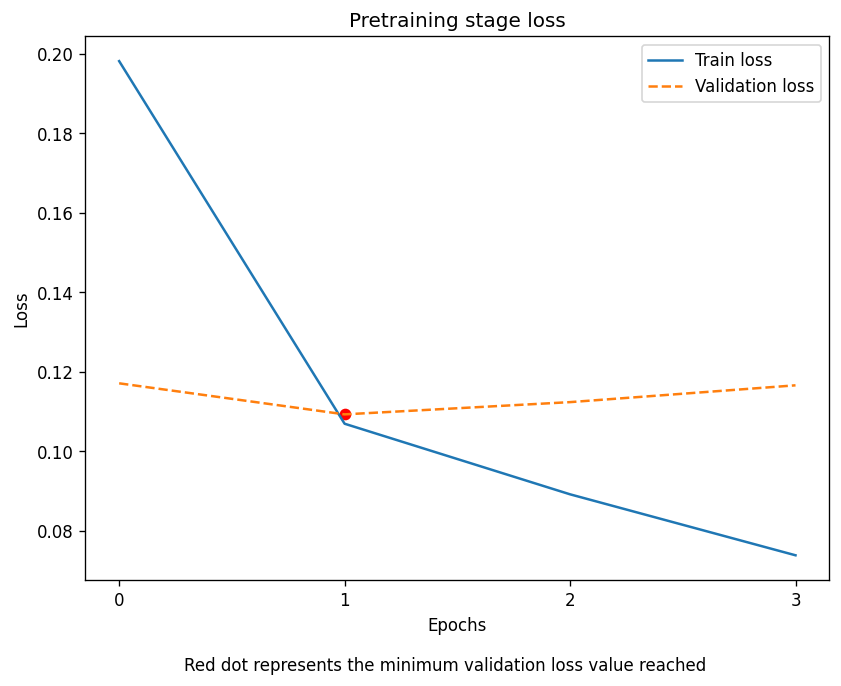

<Figure size 1152x720 with 0 Axes>

In [102]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from typing import List

def plot_losses(train_loss: List[int], validation_loss: List[int], title="", show_minimum=False):
    
    epochs = len(train_loss)
    
    fig = figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
    
    plt.xticks(np.arange(epochs))
    
    plt.plot(train_loss, '-')
    plt.plot(validation_loss, '--')
    
    min_point = np.argmin(validation_loss)
    
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.legend(["Train loss", "Validation loss"])
    
    if show_minimum:
        plt.scatter([min_point], validation_loss[min_point], c='r', marker='o', )
        plt.figtext(.5, .0, "Red dot represents the minimum validation loss value reached", ha='center')
    plt.figure(figsize=(16, 10))
    plt.show()

    
plot_losses(train_losses, validation_losses, "Pretraining stage loss", True)

In [101]:
save_models(pretrained_eae_minimal=pretraining_model)

In [123]:
from transformers import BertForQuestionAnswering


test = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [147]:
class EaEForQuestionAnswering(Module):
    """
    The Entity as Expert model for Question Answering.
    Inspired from HF's BertForQuestionAnswering but simplified.
    """
    def __init__(self,
                   eae: Pretraining):
        """
        :param pretrained_model the pretrained model.
        """
        self.eae = eae
        self.qa_outputs = Linear(eae.config.hidden_states, 2)
        
    
    def forward(*args, input_ids, attention_mask, input_labels):
        # Copycat from BertForQuestionAnswering.forward()
        # Basically a logit on 2 terms with appropriate clamping
        
        _, __, hidden_states = Pretraining.forward(input_ids, attention_mask)
        logits = self.qa_outputs(hidden_states.last_hidden_state)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        
        total_loss = None
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
        
        return total_loss, start_logits, end_logits

In [119]:
pretraining_model = load_model(Pretraining, "pretrained_eae_minimal", model_masked_lm, l0, l1, wikipedia_cbor.max_entity_num,
                                     entity_embedding_size)